In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import scanpy as sc

In [4]:
file = ''
gdata = sc.read_visium(file, count_file=r'GSE198353_mmtv_pymt_GEX_filtered_feature_bc_matrix.h5',load_images=True)
gdata.var_names_make_unique()

In [5]:
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
pdata = sc.read_csv('GSE198353_mmtv_pymt_ADT_t.csv')
pdata.var_names_make_unique()

In [7]:
pdata

AnnData object with n_obs × n_vars = 1978 × 32

In [8]:
pdata.obsm=gdata.obsm

In [9]:
pdata.uns = gdata.uns

In [10]:
pdata

AnnData object with n_obs × n_vars = 1978 × 32
    uns: 'spatial'
    obsm: 'spatial'

In [11]:
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
#Normalization
sc.pp.highly_variable_genes(gdata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(gdata, target_sum=1e4)
sc.pp.log1p(gdata)

In [12]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

In [14]:
gdata

AnnData object with n_obs × n_vars = 1978 × 32286
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [15]:
pdata

AnnData object with n_obs × n_vars = 1978 × 32
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

model.py

In [16]:
import tensorflow.compat.v1 as tf

class GATE():

    def __init__(self, hidden_dims, alpha=0.8, nonlinear=True, weight_decay=0.0001):
        self.n_layers = len(hidden_dims) - 1
        self.alpha = alpha
        self.W, self.v, self.prune_v = self.define_weights(hidden_dims)
        self.C = {}
        self.prune_C = {}
        self.nonlinear = nonlinear
        self.weight_decay = weight_decay

    def __call__(self, A, prune_A, X):
        # Encoder
        H = X
        for layer in range(self.n_layers):
            H = self.__encoder(A, prune_A, H, layer)
            if self.nonlinear:
                if layer != self.n_layers-1:
                    H = tf.nn.elu(H)
        # Final node representations
        self.H = H

        # Decoder
        for layer in range(self.n_layers - 1, -1, -1):
            H = self.__decoder(H, layer)
            if self.nonlinear:
                if layer != 0:
                    H = tf.nn.elu(H)
        X_ = H
        
        # The reconstruction loss of node features
        features_loss = tf.sqrt(tf.reduce_sum(tf.reduce_sum(tf.pow(X - X_, 2))))

        for layer in range(self.n_layers):
            weight_decay_loss = 0
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W[layer]), self.weight_decay, name='weight_loss')

        # Total loss
        self.loss = features_loss  + weight_decay_loss

        if self.alpha == 0:
            self.Att_l = self.C
        else:
            #self.Att_l = {x: (1-self.alpha)*self.C[x] + self.alpha*self.prune_C[x] for x in self.C.keys()}
            self.Att_l = {'C': self.C, 'prune_C': self.prune_C}
        return self.loss, self.H, self.Att_l, X_


    def __encoder(self, A, prune_A, H, layer):
        H = tf.matmul(H, self.W[layer])
        if layer == self.n_layers-1:
            return H
        self.C[layer] = self.graph_attention_layer(A, H, self.v[layer], layer)
        if self.alpha == 0:
            return tf.sparse_tensor_dense_matmul(self.C[layer], H)
        else:
            self.prune_C[layer] = self.graph_attention_layer(prune_A, H, self.prune_v[layer], layer)
            return (1-self.alpha)*tf.sparse_tensor_dense_matmul(self.C[layer], H) + self.alpha*tf.sparse_tensor_dense_matmul(self.prune_C[layer], H)


    def __decoder(self, H, layer):
        H = tf.matmul(H, self.W[layer], transpose_b=True)
        if layer == 0:
            return H
        if self.alpha == 0:
            return tf.sparse_tensor_dense_matmul(self.C[layer-1], H)
        else:
            return (1-self.alpha)*tf.sparse_tensor_dense_matmul(self.C[layer-1], H) + self.alpha*tf.sparse_tensor_dense_matmul(self.prune_C[layer-1], H)


    def define_weights(self, hidden_dims):
        W = {}
        for i in range(self.n_layers):
            W[i] = tf.get_variable("W%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        Ws_att = {}
        for i in range(self.n_layers-1):
            v = {}
            v[0] = tf.get_variable("v%s_0" % i, shape=(hidden_dims[i+1], 1))
            v[1] = tf.get_variable("v%s_1" % i, shape=(hidden_dims[i+1], 1))

            Ws_att[i] = v
        if self.alpha == 0:
            return W, Ws_att, None
        prune_Ws_att = {}
        for i in range(self.n_layers-1):
            prune_v = {}
            prune_v[0] = tf.get_variable("prune_v%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_v[1] = tf.get_variable("prune_v%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_Ws_att[i] = prune_v

        return W, Ws_att, prune_Ws_att

    def graph_attention_layer(self, A, M, v, layer):

        with tf.variable_scope("layer_%s"% layer):
            f1 = tf.matmul(M, v[0])
            f1 = A * f1
            f2 = tf.matmul(M, v[1])
            f2 = A * tf.transpose(f2, [1, 0])
            logits = tf.sparse_add(f1, f2)

            unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
                                         values=tf.nn.sigmoid(logits.values),
                                         dense_shape=logits.dense_shape)
            attentions = tf.sparse_softmax(unnormalized_attentions)

            attentions = tf.SparseTensor(indices=attentions.indices,
                                         values=attentions.values,
                                         dense_shape=attentions.dense_shape)

            return attentions

stagate.py

In [17]:
import tensorflow.compat.v1 as tf
import scipy.sparse as sp
import numpy as np
#from .model import GATE
from tqdm import tqdm

class STAGATE():

    def __init__(self, hidden_dims, alpha, n_epochs=500, lr=0.0001, 
                 gradient_clipping=5, nonlinear=True, weight_decay=0.0001, 
                 verbose=True, random_seed=2020):
        np.random.seed(random_seed)
        tf.set_random_seed(random_seed)
        self.loss_list = []
        self.lr = lr
        self.n_epochs = n_epochs
        self.gradient_clipping = gradient_clipping
        self.build_placeholders()
        self.verbose = verbose
        self.alpha = alpha
        self.gate = GATE(hidden_dims, alpha, nonlinear, weight_decay)
        self.loss, self.H, self.C, self.ReX = self.gate(self.A, self.prune_A, self.X)
        self.optimize(self.loss)
        self.build_session()

    def build_placeholders(self):
        self.A = tf.sparse_placeholder(dtype=tf.float32)
        self.prune_A = tf.sparse_placeholder(dtype=tf.float32)
        self.X = tf.placeholder(dtype=tf.float32)

    def build_session(self, gpu= True):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        if gpu == False:
            config.intra_op_parallelism_threads = 0
            config.inter_op_parallelism_threads = 0
        self.session = tf.Session(config=config)
        self.session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

    def optimize(self, loss):
        optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        gradients, variables = zip(*optimizer.compute_gradients(loss))
        gradients, _ = tf.clip_by_global_norm(gradients, self.gradient_clipping)
        self.train_op = optimizer.apply_gradients(zip(gradients, variables))

    def __call__(self, A, prune_A, X):
        for epoch in tqdm(range(self.n_epochs)):
            self.run_epoch(epoch, A, prune_A, X)

    def run_epoch(self, epoch, A, prune_A, X):

        loss, _ = self.session.run([self.loss, self.train_op],
                                         feed_dict={self.A: A,
                                                    self.prune_A: prune_A,
                                                    self.X: X})
        self.loss_list.append(loss)
        #if self.verbose:
        #    print("Epoch: %s, Loss: %.4f" % (epoch, loss))
        return loss

    def infer(self, A, prune_A, X):
        H, C, ReX = self.session.run([self.H, self.C, self.ReX],
                           feed_dict={self.A: A,
                                      self.prune_A: prune_A,
                                      self.X: X})

        return H, self.Conbine_Atten_l(C), self.loss_list, ReX

    def Conbine_Atten_l(self, input):
        if self.alpha == 0:
            return [sp.coo_matrix((input[layer][1], (input[layer][0][:, 0], input[layer][0][:, 1])), shape=(input[layer][2][0], input[layer][2][1])) for layer in input]
        else:
            Att_C = [sp.coo_matrix((input['C'][layer][1], (input['C'][layer][0][:, 0], input['C'][layer][0][:, 1])), shape=(input['C'][layer][2][0], input['C'][layer][2][1])) for layer in input['C']]
            Att_pruneC = [sp.coo_matrix((input['prune_C'][layer][1], (input['prune_C'][layer][0][:, 0], input['prune_C'][layer][0][:, 1])), shape=(input['prune_C'][layer][2][0], input['prune_C'][layer][2][1])) for layer in input['prune_C']]
            return [self.alpha*Att_pruneC[layer] + (1-self.alpha)*Att_C[layer] for layer in input['C']]


train_stagate.py

In [37]:
import numpy as np
import scipy.sparse as sp
#from .STAGATE import STAGATE
import tensorflow.compat.v1 as tf
import pandas as pd
import scanpy as sc

def train_STAGATE(adata1,adata2, 
                hidden_dims1=[512, 30], alpha1=0, n_epochs1=500, lr1=0.0001, key_added1='STAGATE',
                gradient_clipping1=5, nonlinear1=True, weight_decay1=0.0001,verbose1=True, 
                random_seed1=2020, pre_label1s=None, pre_resolution1=0.2,
                save_attention1=False, save_loss1=False, save_reconstrction1=False,
                hidden_dims2=[512, 30], alpha2=0, n_epochs2=500, lr2=0.0001, key_added2='STAGATE',
                gradient_clipping2=5, nonlinear2=True, weight_decay2=0.0001,verbose2=True, 
                random_seed2=2020, pre_label1s2=None, pre_resolution2=0.2,
                save_attention2=False, save_loss2=False, save_reconstrction2=False):
    """\
    Training graph attention auto-encoder.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    hidden_dims
        The dimension of the encoder.
    alpha
        The weight of cell type-aware spatial neighbor network.
    n_epochs
        Number of total epochs in training.
    lr
        Learning rate for AdamOptimizer.
    key_added
        The latent embeddings are saved in adata.obsm[key_added].
    gradient_clipping
        Gradient Clipping.
    nonlinear
        If True, the nonlinear avtivation is performed.
    weight_decay
        Weight decay for AdamOptimizer.
    pre_labels
        The key in adata.obs for the manually designate the pre-clustering results. Only used when alpha>0.
    pre_resolution
        The resolution parameter of sc.tl.louvain for the pre-clustering. Only used when alpha>0 and per_labels==None.
    save_attention
        If True, the weights of the attention layers are saved in adata.uns['STAGATE_attention']
    save_loss
        If True, the training loss is saved in adata.uns['STAGATE_loss'].
    save_reconstrction
        If True, the reconstructed expression profiles are saved in adata.layers['STAGATE_ReX'].

    Returns
    -------
    AnnData
    """

    tf.reset_default_graph()
    np.random.seed(random_seed1)
    tf.set_random_seed(random_seed1)
    if 'highly_variable' in adata1.var.columns:
        adata_Vars =  adata1[:, adata1.var['highly_variable']]
    else:
        adata_Vars = adata1
    X = pd.DataFrame(adata_Vars.X[:, ].toarray(), index=adata_Vars.obs.index, columns=adata_Vars.var.index)
    if verbose1:
        print('Size of Input: ', adata_Vars.shape)
    cells = np.array(X.index)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    if 'Spatial_Net' not in adata1.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")
    Spatial_Net = adata1.uns['Spatial_Net']
    G_df = Spatial_Net.copy()
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)
    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata1.n_obs, adata1.n_obs))
    G_tf = prepare_graph_data(G)

    tf.compat.v1.disable_eager_execution()
    
    trainer1 = STAGATE(hidden_dims=[X.shape[1]] + hidden_dims1, alpha=alpha1, 
                    n_epochs=n_epochs1, lr=lr1, gradient_clipping=gradient_clipping1, 
                    nonlinear=nonlinear1,weight_decay=weight_decay1, verbose=verbose1, 
                    random_seed=random_seed1)
    if alpha1 == 0:
        trainer1(G_tf, G_tf, X)
        embeddings, attentions, loss, ReX= trainer1.infer(G_tf, G_tf, X)
    else:
        G_df = Spatial_Net.copy()
        if pre_labels==None:
            if verbose1:
                print('------Pre-clustering using louvain with resolution=%.2f' %pre_resolution1)
            sc.tl.pca(adata1, svd_solver='arpack')
            sc.pp.neighbors(adata1)
            sc.tl.louvain(adata1, resolution=pre_resolution1, key_added='expression_louvain_label')
            pre_labels = 'expression_louvain_label'
        prune_G_df = prune_spatial_Net(G_df, adata1.obs[pre_labels])
        prune_G_df['Cell1'] = prune_G_df['Cell1'].map(cells_id_tran)
        prune_G_df['Cell2'] = prune_G_df['Cell2'].map(cells_id_tran)
        prune_G = sp.coo_matrix((np.ones(prune_G_df.shape[0]), (prune_G_df['Cell1'], prune_G_df['Cell2'])))
        prune_G_tf = prepare_graph_data(prune_G)
        prune_G_tf = (prune_G_tf[0], prune_G_tf[1], G_tf[2])
        trainer1(G_tf, prune_G_tf, X)
        embeddings, attentions, loss, ReX = trainer1.infer(G_tf, prune_G_tf, X)
    global df1
    
    cell_reps = pd.DataFrame(embeddings)
    df1=cell_reps
    cell_reps.index = cells

    adata1.obsm[key_added1] = cell_reps.loc[adata1.obs_names, ].values
    if save_attention1:
        adata1.uns['STAGATE_attention'] = attentions
    if save_loss1:
        adata1.uns['STAGATE_loss'] = loss
    if save_reconstrction1:
        ReX = pd.DataFrame(ReX, index=X.index, columns=X.columns)
        ReX[ReX<0] = 0
        adata1.layers['STAGATE_ReX'] = ReX.values





    tf.reset_default_graph()
    np.random.seed(random_seed2)
    tf.set_random_seed(random_seed2)
    if 'highly_variable' in adata2.var.columns:
        adata_Vars =  adata2[:, adata2.var['highly_variable']]
    else:
        adata_Vars = adata2
    X = pd.DataFrame(adata_Vars.X[:, ], index=adata_Vars.obs.index, columns=adata_Vars.var.index)
    if verbose2:
        print('Size of Input: ', adata_Vars.shape)
    cells = np.array(X.index)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    if 'Spatial_Net' not in adata2.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")
    Spatial_Net = adata2.uns['Spatial_Net']
    G_df = Spatial_Net.copy()
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)
    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata2.n_obs, adata2.n_obs))
    G_tf = prepare_graph_data(G)

    #trainer 2    
    trainer2 = STAGATE(hidden_dims=[X.shape[1]] + hidden_dims2, alpha=alpha2, 
                    n_epochs=n_epochs2, lr=lr2, gradient_clipping=gradient_clipping2, 
                    nonlinear=nonlinear2,weight_decay=weight_decay2, verbose=verbose2, 
                    random_seed=random_seed2)
    if alpha2 == 0:
        trainer2(G_tf, G_tf, X)
        embeddings, attentions, loss, ReX= trainer2.infer(G_tf, G_tf, X)
    else:
        G_df = Spatial_Net.copy()
        if pre_labels==None:
            if verbose2:
                print('------Pre-clustering using louvain with resolution=%.2f' %pre_resolution2)
            sc.tl.pca(adata2, svd_solver='arpack')
            sc.pp.neighbors(adata2)
            sc.tl.louvain(adata2, resolution=pre_resolution2, key_added='expression_louvain_label')
            pre_labels = 'expression_louvain_label'
        prune_G_df = prune_spatial_Net(G_df, adata2.obs[pre_labels])
        prune_G_df['Cell1'] = prune_G_df['Cell1'].map(cells_id_tran)
        prune_G_df['Cell2'] = prune_G_df['Cell2'].map(cells_id_tran)
        prune_G = sp.coo_matrix((np.ones(prune_G_df.shape[0]), (prune_G_df['Cell1'], prune_G_df['Cell2'])))
        prune_G_tf = prepare_graph_data(prune_G)
        prune_G_tf = (prune_G_tf[0], prune_G_tf[1], G_tf[2])
        trainer2(G_tf, prune_G_tf, X)
        embeddings, attentions, loss, ReX = trainer2.infer(G_tf, prune_G_tf, X)
    global df2
    
    cell_reps = pd.DataFrame(embeddings)
    df2=cell_reps
    cell_reps.index = cells

    adata2.obsm[key_added2] = cell_reps.loc[adata2.obs_names, ].values
    if save_attention2:
        adata2.uns['STAGATE_attention'] = attentions
    if save_loss2:
        adata2.uns['STAGATE_loss'] = loss
    if save_reconstrction2:
        ReX = pd.DataFrame(ReX, index=X.index, columns=X.columns)
        ReX[ReX<0] = 0
        adata2.layers['STAGATE_ReX'] = ReX.values
    

    
    return adata2


def prune_spatial_Net(Graph_df, label):
    print('------Pruning the graph...')
    print('%d edges before pruning.' %Graph_df.shape[0])
    pro_labels_dict = dict(zip(list(label.index), label))
    Graph_df['Cell1_label'] = Graph_df['Cell1'].map(pro_labels_dict)
    Graph_df['Cell2_label'] = Graph_df['Cell2'].map(pro_labels_dict)
    Graph_df = Graph_df.loc[Graph_df['Cell1_label']==Graph_df['Cell2_label'],]
    print('%d edges after pruning.' %Graph_df.shape[0])
    return Graph_df


def prepare_graph_data(adj):
    # adapted from preprocess_adj_bias
    num_nodes = adj.shape[0]
    adj = adj + sp.eye(num_nodes)# self-loop
    #data =  adj.tocoo().data
    #adj[adj > 0.0] = 1.0
    if not sp.isspmatrix_coo(adj):
        adj = adj.tocoo()
    adj = adj.astype(np.float32)
    indices = np.vstack((adj.col, adj.row)).transpose()
    return (indices, adj.data, adj.shape)

def recovery_Imputed_Count(adata, size_factor):
    assert('ReX' in adata.uns)
    temp_df = adata.uns['ReX'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count'] = temp_df
    return adata

    


utils.py

In [19]:
import pandas as pd
import numpy as np
import sklearn.neighbors


def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.
    
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net


def Cal_Spatial_Net_3D(adata, rad_cutoff_2D, rad_cutoff_Zaxis,
                       key_section='Section_id', section_order=None, verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff_2D
        radius cutoff for 2D SNN construction.
    rad_cutoff_Zaxis
        radius cutoff for 2D SNN construction for consturcting SNNs between adjacent sections.
    key_section
        The columns names of section_ID in adata.obs.
    section_order
        The order of sections. The SNNs between adjacent sections are constructed according to this order.
    
    Returns
    -------
    The 3D spatial networks are saved in adata.uns['Spatial_Net'].
    """
    adata.uns['Spatial_Net_2D'] = pd.DataFrame()
    adata.uns['Spatial_Net_Zaxis'] = pd.DataFrame()
    num_section = np.unique(adata.obs[key_section]).shape[0]
    if verbose:
        print('Radius used for 2D SNN:', rad_cutoff_2D)
        print('Radius used for SNN between sections:', rad_cutoff_Zaxis)
    for temp_section in np.unique(adata.obs[key_section]):
        if verbose:
            print('------Calculating 2D SNN of section ', temp_section)
        temp_adata = adata[adata.obs[key_section] == temp_section, ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_2D, verbose=False)
        temp_adata.uns['Spatial_Net']['SNN'] = temp_section
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_2D'] = pd.concat(
            [adata.uns['Spatial_Net_2D'], temp_adata.uns['Spatial_Net']])
    for it in range(num_section-1):
        section_1 = section_order[it]
        section_2 = section_order[it+1]
        if verbose:
            print('------Calculating SNN between adjacent section %s and %s.' %
                  (section_1, section_2))
        Z_Net_ID = section_1+'-'+section_2
        temp_adata = adata[adata.obs[key_section].isin(
            [section_1, section_2]), ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_Zaxis, verbose=False)
        spot_section_trans = dict(
            zip(temp_adata.obs.index, temp_adata.obs[key_section]))
        temp_adata.uns['Spatial_Net']['Section_id_1'] = temp_adata.uns['Spatial_Net']['Cell1'].map(
            spot_section_trans)
        temp_adata.uns['Spatial_Net']['Section_id_2'] = temp_adata.uns['Spatial_Net']['Cell2'].map(
            spot_section_trans)
        used_edge = temp_adata.uns['Spatial_Net'].apply(
            lambda x: x['Section_id_1'] != x['Section_id_2'], axis=1)
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[used_edge, ]
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[:, [
            'Cell1', 'Cell2', 'Distance']]
        temp_adata.uns['Spatial_Net']['SNN'] = Z_Net_ID
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_Zaxis'] = pd.concat(
            [adata.uns['Spatial_Net_Zaxis'], temp_adata.uns['Spatial_Net']])
    adata.uns['Spatial_Net'] = pd.concat(
        [adata.uns['Spatial_Net_2D'], adata.uns['Spatial_Net_Zaxis']])
    if verbose:
        print('3D SNN contains %d edges, %d cells.' %
            (adata.uns['Spatial_Net'].shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %
            (adata.uns['Spatial_Net'].shape[0]/adata.n_obs))

def Stats_Spatial_Net(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Cell1'].shape[0]
    Mean_edge = Num_edge/adata.shape[0]
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
    plot_df = plot_df/adata.shape[0]
    fig, ax = plt.subplots(figsize=[3,2])
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.title('Number of Neighbors (Mean=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df)

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata


Trying and debugging arch for new code

------Calculating spatial graph...
The graph contains 22532 edges, 1978 cells.
11.3913 neighbors per cell on average.


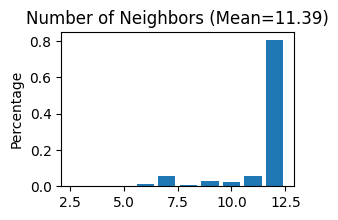

In [21]:
Cal_Spatial_Net(gdata, rad_cutoff=150)
Stats_Spatial_Net(gdata)

------Calculating spatial graph...
The graph contains 22532 edges, 1978 cells.
11.3913 neighbors per cell on average.


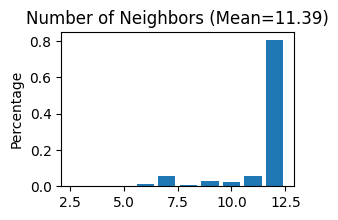

In [22]:
Cal_Spatial_Net(pdata, rad_cutoff=150)
Stats_Spatial_Net(pdata)

In [38]:
adata = train_STAGATE(gdata,pdata, alpha1=0)

Size of Input:  (1978, 3000)


100%|██████████| 500/500 [01:33<00:00,  5.37it/s]


Size of Input:  (1978, 32)


100%|██████████| 500/500 [00:49<00:00, 10.03it/s]


In [39]:
df1

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
AAACAAGTATCTCCCA-1,0.938439,-5.388919,-0.481878,-2.402828,0.601247,-2.131083,-3.221389,2.924710,2.578420,-10.444286,...,2.138795,3.677836,2.600389,8.657686,-0.204813,8.584451,1.874219,-0.174053,0.130756,-2.904883
AAACACCAATAACTGC-1,1.320922,-9.141916,-1.472456,-2.862338,2.698369,-2.667460,-2.442187,6.854365,4.044033,-11.871183,...,5.048841,6.871148,5.176989,9.033352,-0.097700,10.890814,2.941828,-3.364100,-0.782305,-3.215613
AAACAGGGTCTATATT-1,1.658552,-8.592293,0.660172,-1.153248,0.754840,-1.569785,-2.572051,7.700145,2.731440,-6.830016,...,0.016048,4.082165,2.099938,7.702282,0.043255,10.634283,5.750100,1.466714,-0.204753,0.772126
AAACAGTGTTCCTGGG-1,0.508062,-7.970939,-0.735657,-0.465459,2.929976,-4.096318,-3.200086,7.768314,4.766773,-11.317054,...,2.858887,5.766397,4.758441,11.569694,-0.199938,11.900747,1.313654,-5.145318,-0.240854,-4.707025
AAACATGGTGAGAGGA-1,2.861011,-9.899363,0.982959,-0.780340,1.254355,-2.744068,-1.735403,5.864057,3.501144,-11.064241,...,4.301721,7.447367,3.133896,8.981826,-2.166147,11.993219,3.092735,0.513573,-1.334396,-2.684921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGGCAATGACTG-1,1.132038,-9.269597,-1.904902,-1.951417,2.087080,-4.371450,-2.271594,7.928358,4.205534,-12.463930,...,4.257366,5.956852,4.721883,10.980147,-0.169988,12.758412,2.257046,-5.726015,-1.027241,-5.112778
TTGTTTCACATCCAGG-1,0.049955,-7.297412,-1.418458,-1.461516,2.517338,-3.333785,-3.350011,7.986782,4.642964,-10.806738,...,3.517180,6.759200,4.982315,10.785184,1.144763,11.033932,2.079479,-4.584883,-0.255178,-3.871679
TTGTTTCATTAGTCTA-1,0.452143,-7.943635,-0.483302,-1.056167,3.413105,-2.622405,-2.847074,8.538589,4.820097,-11.033499,...,3.184027,6.378491,5.588036,10.531120,0.116594,10.950959,1.449842,-5.007567,-0.056432,-4.084251
TTGTTTCCATACAACT-1,1.379791,-7.916517,0.868818,-0.586092,2.561590,-1.841341,-3.579016,7.819226,3.785060,-9.681257,...,1.916534,6.659756,3.848663,8.491096,0.032048,9.893155,4.591046,-0.418995,-1.081914,-2.114244


In [40]:
df2

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
AAACAAGTATCTCCCA-1,5.199482,1.910534,2.845368,5.000886,6.300559,4.748518,3.048665,-9.818274,2.492618,-2.586437,...,6.070517,1.923586,-6.526998,-1.847581,7.393299,-7.895078,4.329330,5.059249,-6.500504,-6.893833
AAACACCAATAACTGC-1,5.087050,1.868339,2.906760,5.108169,6.303226,4.760905,2.875792,-10.162344,2.555545,-2.991873,...,6.137857,1.870929,-6.534774,-2.266585,7.573514,-7.656299,4.240398,5.104081,-6.382413,-6.944314
AAACAGGGTCTATATT-1,5.017549,2.351588,3.352271,5.279071,6.257076,4.167795,2.438459,-10.411140,2.499317,-3.543744,...,6.470036,2.689917,-7.109770,-2.842032,8.168330,-7.407270,4.738400,4.961537,-6.189116,-7.071371
AAACAGTGTTCCTGGG-1,5.092148,1.820835,2.843175,5.106685,6.338550,4.846375,3.077793,-9.968822,2.470895,-2.859653,...,6.152143,1.870688,-6.514985,-2.122399,7.492480,-7.743516,4.268391,5.081753,-6.543011,-6.973835
AAACATGGTGAGAGGA-1,5.204985,2.152406,3.067887,5.139355,6.302631,4.506183,2.735886,-10.245228,2.660770,-3.192692,...,6.376112,2.250368,-6.820250,-2.461908,7.823659,-7.649456,4.514001,4.941995,-6.355417,-7.012464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGGCAATGACTG-1,4.916677,1.871615,3.017054,5.247950,6.376088,4.742883,3.025579,-10.194869,2.352205,-3.143674,...,6.229505,2.062171,-6.585307,-2.376214,7.653180,-7.570425,4.247721,5.188359,-6.523009,-7.063677
TTGTTTCACATCCAGG-1,5.135064,1.745847,2.821859,5.068168,6.314626,4.892006,2.998827,-10.059114,2.544152,-2.869155,...,6.116751,1.634509,-6.357988,-2.078263,7.446054,-7.704402,4.162888,5.024352,-6.390822,-6.923780
TTGTTTCATTAGTCTA-1,5.022541,1.717610,2.858531,5.078684,6.293603,4.881103,2.893639,-10.103867,2.489672,-3.002120,...,6.085191,1.643967,-6.341611,-2.238788,7.451520,-7.566065,4.094690,5.137383,-6.369180,-6.926561
TTGTTTCCATACAACT-1,5.085529,2.252144,3.248734,5.249969,6.245845,4.352278,2.574226,-10.322430,2.591817,-3.396513,...,6.352485,2.396352,-7.002429,-2.618903,7.953867,-7.515792,4.513474,5.038323,-6.229646,-7.045275


In [42]:
df = pd.concat([df1, df2], axis=1)

In [53]:
new_columns = list(range(60))
df.columns = new_columns


In [54]:
df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
AAACAAGTATCTCCCA-1,0.938439,-5.388919,-0.481878,-2.402828,0.601247,-2.131083,-3.221389,2.924710,2.578420,-10.444286,...,6.070517,1.923586,-6.526998,-1.847581,7.393299,-7.895078,4.329330,5.059249,-6.500504,-6.893833
AAACACCAATAACTGC-1,1.320922,-9.141916,-1.472456,-2.862338,2.698369,-2.667460,-2.442187,6.854365,4.044033,-11.871183,...,6.137857,1.870929,-6.534774,-2.266585,7.573514,-7.656299,4.240398,5.104081,-6.382413,-6.944314
AAACAGGGTCTATATT-1,1.658552,-8.592293,0.660172,-1.153248,0.754840,-1.569785,-2.572051,7.700145,2.731440,-6.830016,...,6.470036,2.689917,-7.109770,-2.842032,8.168330,-7.407270,4.738400,4.961537,-6.189116,-7.071371
AAACAGTGTTCCTGGG-1,0.508062,-7.970939,-0.735657,-0.465459,2.929976,-4.096318,-3.200086,7.768314,4.766773,-11.317054,...,6.152143,1.870688,-6.514985,-2.122399,7.492480,-7.743516,4.268391,5.081753,-6.543011,-6.973835
AAACATGGTGAGAGGA-1,2.861011,-9.899363,0.982959,-0.780340,1.254355,-2.744068,-1.735403,5.864057,3.501144,-11.064241,...,6.376112,2.250368,-6.820250,-2.461908,7.823659,-7.649456,4.514001,4.941995,-6.355417,-7.012464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGGCAATGACTG-1,1.132038,-9.269597,-1.904902,-1.951417,2.087080,-4.371450,-2.271594,7.928358,4.205534,-12.463930,...,6.229505,2.062171,-6.585307,-2.376214,7.653180,-7.570425,4.247721,5.188359,-6.523009,-7.063677
TTGTTTCACATCCAGG-1,0.049955,-7.297412,-1.418458,-1.461516,2.517338,-3.333785,-3.350011,7.986782,4.642964,-10.806738,...,6.116751,1.634509,-6.357988,-2.078263,7.446054,-7.704402,4.162888,5.024352,-6.390822,-6.923780
TTGTTTCATTAGTCTA-1,0.452143,-7.943635,-0.483302,-1.056167,3.413105,-2.622405,-2.847074,8.538589,4.820097,-11.033499,...,6.085191,1.643967,-6.341611,-2.238788,7.451520,-7.566065,4.094690,5.137383,-6.369180,-6.926561
TTGTTTCCATACAACT-1,1.379791,-7.916517,0.868818,-0.586092,2.561590,-1.841341,-3.579016,7.819226,3.785060,-9.681257,...,6.352485,2.396352,-7.002429,-2.618903,7.953867,-7.515792,4.513474,5.038323,-6.229646,-7.045275


In [55]:
gdata_Vars =  gdata[:, gdata.var['highly_variable']]
pdata_Vars =  pdata

X1 = pd.DataFrame(gdata_Vars.X[:, ].toarray(), index=gdata_Vars.obs.index, columns=gdata_Vars.var.index)
cells1 = np.array(X1.index)

X2 = pd.DataFrame(pdata_Vars.X[:, ], index=pdata_Vars.obs.index, columns=pdata_Vars.var.index)
cells2 = np.array(X2.index)

In [56]:
df.index = cells1
gdata.obsm['test'] = df.loc[gdata.obs_names, ].values


In [57]:
gdata.obsm['test']

array([[ 0.93843925, -5.3889194 , -0.48187792, ...,  5.059249  ,
        -6.5005035 , -6.893833  ],
       [ 1.3209221 , -9.141916  , -1.4724565 , ...,  5.104081  ,
        -6.382413  , -6.9443135 ],
       [ 1.6585524 , -8.592293  ,  0.66017246, ...,  4.9615374 ,
        -6.189116  , -7.0713706 ],
       ...,
       [ 0.4521433 , -7.943635  , -0.48330188, ...,  5.1373825 ,
        -6.3691797 , -6.926561  ],
       [ 1.3797913 , -7.9165173 ,  0.8688179 , ...,  5.0383234 ,
        -6.2296457 , -7.0452747 ],
       [ 0.26863408, -8.062486  , -0.8489468 , ...,  5.05977   ,
        -6.5286655 , -6.947697  ]], dtype=float32)

In [46]:
pdata

AnnData object with n_obs × n_vars = 1978 × 32
    uns: 'spatial', 'log1p', 'hvg', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'

In [36]:
type(gdata.obsm['STAGATE'])

numpy.ndarray

In [16]:
r"C:\Users\KARAN\AppData\Local\R\win-library\4.3\spatialLIBD\data"

'C:\\Users\\KARAN\\AppData\\Local\\R\\win-library\\4.3\\spatialLIBD\\data'

In [59]:
sc.pp.neighbors(gdata, use_rep='test')
sc.tl.umap(gdata)
#adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=5)

In [60]:
# Write the 'data' variable to a file in CSV format
np.savetxt('data.csv', gdata.obsm['test'], delimiter=',')


In [61]:
# Read the result from the file
result = np.loadtxt('results.csv', delimiter=',')
# Print the result
print(result)


[1. 5. 3. ... 2. 3. 4.]


In [27]:
mclust_res = result
adata.obs['mclust'] = mclust_res
adata.obs['mclust'] = adata.obs['mclust'].astype('int')
adata.obs['mclust'] = adata.obs['mclust'].astype('category')
obs_df = adata.obs.dropna()


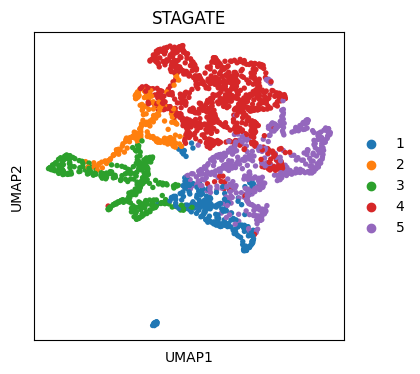

In [28]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["mclust"], title=['STAGATE'])

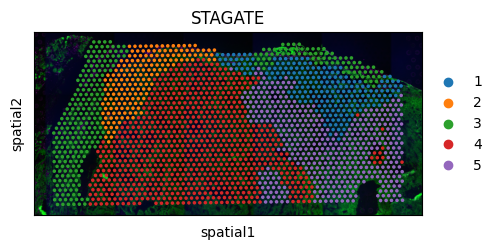

In [29]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, color=["mclust"], title=['STAGATE'])

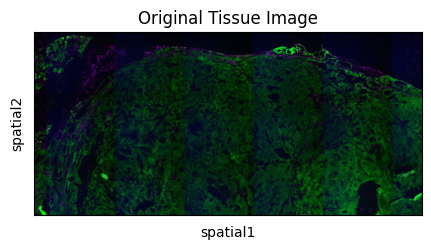

In [ ]:
sc.pl.spatial(adata,  title=['Original Tissue Image'])

In [66]:
mclust_res = result
gdata.obs['mclust'] = mclust_res
gdata.obs['mclust'] = gdata.obs['mclust'].astype('int')
gdata.obs['mclust'] = gdata.obs['mclust'].astype('category')
obs_df = gdata.obs.dropna()


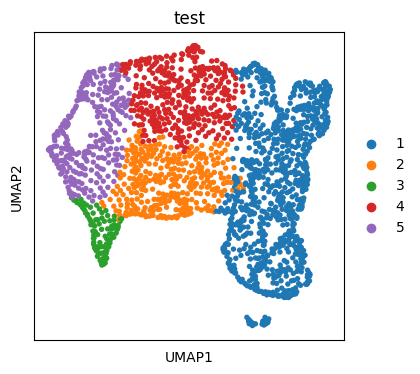

In [69]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(gdata, color=["mclust"], title=['test'])

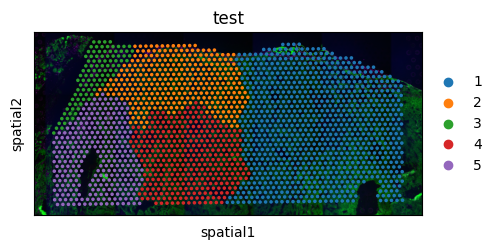

In [68]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(gdata, color=["mclust"], title=['test'])